In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import time

%matplotlib inline

# Loading in and dividing data
# reads in data
dir_path = os.path.dirname(os.path.realpath("depth_main.py"))
npy_folder = os.path.join(dir_path, "depth")
images = np.load(os.path.join(npy_folder, "images64.npy"))
pv_out = np.load(os.path.join(npy_folder, "pv_outputs.npy"))

# randomly divides into a training set and a validation set
side_len = 64
width_base = 4
num_imgs = images.shape[0]
indices = np.arange(num_imgs)
np.random.shuffle(indices)
X_train, X_val = images[indices[:int(0.8 * num_imgs)]], images[indices[int(0.8 * num_imgs):]]
y_train, y_val = pv_out[indices[:int(0.8 * num_imgs)]], pv_out[indices[int(0.8 * num_imgs):]]

# generate an array of filter number
min_depth = 3
max_depth = 9
step_width = 1
model_depth = np.arange(min_width, max_width + 1, step_width)

In [6]:
# The model
def cnn_depth_model(X, y, is_training,depth):
    # CBP sandwich 1
    conv1 = tf.layers.conv2d(
        inputs=X,
        filters=width_base,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu)
    bn1 = tf.layers.batch_normalization(inputs=conv1, axis=1)
    if depth <=3:
        bn2 = bn1
    else:
        conv2 = tf.layers.conv2d(
            inputs=bn1,
            filters=width_base,
            kernel_size=[3, 3],
            padding="same",
            activation=tf.nn.relu)
        bn2 = tf.layers.batch_normalization(inputs=conv2, axis=1)
    pool1 = tf.layers.max_pooling2d(inputs=bn2, pool_size=[2, 2], strides=2)

    # CBP sandwich 2
    conv3 = tf.layers.conv2d(
        inputs=pool1,
        filters=width_base*2,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu)
    bn3 = tf.layers.batch_normalization(inputs=conv3, axis=1)
    
    if depth<=4:
        bn4 = bn3
    else:
        conv4 = tf.layers.conv2d(
            inputs=bn3,
            filters=width_base*2,
            kernel_size=[3, 3],
            padding="same",
            activation=tf.nn.relu)
        bn4 = tf.layers.batch_normalization(inputs=conv4, axis=1)
    
    if depth<=5:
        bn5= bn4
    else:
        conv5 = tf.layers.conv2d(
            inputs=pool1,
            filters=width_base*2,
            kernel_size=[3, 3],
            padding="same",
            activation=tf.nn.relu)
        bn5 = tf.layers.batch_normalization(inputs=conv5, axis=1)
    if depth<=6:
        bn6= bn5
    else:
        conv6 = tf.layers.conv2d(
            inputs=bn5,
            filters=width_base*2,
            kernel_size=[3, 3],
            padding="same",
            activation=tf.nn.relu)
        bn6 = tf.layers.batch_normalization(inputs=conv6, axis=1)
    pool2 = tf.layers.max_pooling2d(inputs=bn6, pool_size=[2, 2], strides=2)
    
    # Fully connected nets
    pool2_flat = tf.reshape(pool2, [-1, int(side_len/4*side_len/4*width_base*2)])

    # Fully connected nets
    dense1 = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    bn_dense1 = tf.layers.batch_normalization(inputs=dense1)   
    dropout1 = tf.layers.dropout(inputs=bn_dense1, rate=0.4, training=is_training)
    if depth<=7:
        dropout2 = dropout1
    else:
        dense2 = tf.layers.dense(inputs=dropout1, units=1024, activation=tf.nn.relu)
        bn_dense2 = tf.layers.batch_normalization(inputs=dense2)
        dropout2 = tf.layers.dropout(inputs=bn_dense2, rate=0.4, training=is_training)
    if depth<=8:
        dropout3 = dropout2
    else:
        dense3 = tf.layers.dense(inputs=dropout2, units=1024, activation=tf.nn.relu)
        bn_dense3 = tf.layers.batch_normalization(inputs=dense3)
        dropout3 = tf.layers.dropout(inputs=bn_dense3, rate=0.4, training=is_training)
    
    regression = tf.layers.dense(inputs=dropout3, units=1)
    regression = tf.reshape(regression, [-1])
    return regression

In [7]:
# Run model 
def run_model(session, pred_y_var, loss_var,
              x_var,y_var,is_training, Xd, yd,
              epoch_idx=0, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    rel_err_var = tf.divide(tf.abs(tf.subtract(y_var, pred_y_var)), y_var)
    accuracy = tf.reduce_mean(rel_err_var)

    # shuffle indices
    train_indices = np.arange(Xd.shape[0])
    np.random.shuffle(train_indices)
    training_now = training is not None

    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [loss_var, rel_err_var, accuracy]
    if training_now:
        variables[-1] = training

    # counter
    iter_cnt = 0

    # keep track of losses and accuracy
    errors = 0
    losses = []

    # make sure we iterate over the dataset once
    for i in range(int(Xd.shape[0] / batch_size)+1):
        # generate indices for the batch
        start_idx = (i * batch_size) % Xd.shape[0]
        idx = train_indices[start_idx:start_idx + batch_size]

        # create a feed dictionary for this batch
        feed_dict = {x_var: Xd[idx, :],
                     y_var: yd[idx],
                     is_training: training_now}
        # get batch size
        actual_batch_size = yd[i:i + batch_size].shape[0]

        # have tensorflow compute loss and correct predictions
        # and (if given) perform a training step
        loss, rel_err, _ = session.run(variables, feed_dict=feed_dict)

        # aggregate performance stats
        losses.append(loss * actual_batch_size)
        errors += np.sum(rel_err)

        # print every now and then
        if training_now and (iter_cnt % print_every) == 0:
            print("Iteration {0}: with minibatch training loss = {1:.3g} and relative error of {2:.2g}"
                  .format(iter_cnt, loss, np.sum(rel_err) / actual_batch_size))
        iter_cnt += 1
    total_error = errors / Xd.shape[0]
    total_loss = np.sum(losses) / Xd.shape[0]

    print("Epoch {2}, Overall loss = {0:.3g} and relative error of {1:.3g}"
          .format(total_loss, total_error, epoch_idx+1 ))

    if plot_losses:
        plt.plot(losses)
        plt.grid(True)
        plt.title('Epoch {} Loss'.format(epoch_idx + 1))
        plt.xlabel('minibatch number')
        plt.ylabel('minibatch loss')
        plt.show()

    return total_loss, total_error

In [11]:
# load PV output
num_epochs = 45

# initialize loss and rel_err history list
train_loss_hist = np.zeros([model_width.size, num_epochs], dtype='float32')
train_error_hist = np.zeros_like(train_loss_hist)
val_loss_hist = np.zeros_like(train_loss_hist)
val_error_hist = np.zeros_like(train_loss_hist)

for i in range(model_width.size):

    # Loading in and dividing data
    width_base = model_width[i]

    # Build computational graph
    tf.reset_default_graph()  # Reset computational graph

    x_var = tf.placeholder(tf.float32, [None, side_len, side_len, 3])  # x variable
    y_var = tf.placeholder(tf.float32, [None])  # y variable
    is_training = tf.placeholder(tf.bool)  # flag
    pred_y_var = cnn_depth_model(x_var, y_var, is_training,width_base)  # model in use
    mean_loss = tf.losses.mean_squared_error(y_var, pred_y_var)  # loss in use

    # Define optimizer and optimize session parameter
    # define optimizer
    optimizer = tf.train.AdamOptimizer(1e-3)
    # batch normalization in tensorflow requires this extra dependency
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    with tf.control_dependencies(extra_update_ops):
        train_step = optimizer.minimize(mean_loss)
    pass
    
    with tf.Session() as sess:
        with tf.device("/gpu:0"): # cpu or gpu
            # initialize all variable
            sess.run(tf.global_variables_initializer())
    
            for epoch_idx in range(num_epochs):
                print('For model width base: {0}'.format(width_base))
                tic = time.process_time()
                print('Training')
                train_loss, train_error = run_model(sess, pred_y_var, mean_loss,
                                                    x_var, y_var, is_training,
                                                    X_train, y_train, epoch_idx, 100, 20, train_step, False)
                tac = time.process_time()
                print('Training time of this epoch: ',tac-tic,'s')
                print('Validation')
                val_loss, val_error = run_model(sess, pred_y_var, mean_loss,
                                                x_var, y_var, is_training, X_val, y_val)
    
                train_loss_hist[i, epoch_idx] = train_loss
                train_error_hist[i, epoch_idx] = train_error
                val_loss_hist[i, epoch_idx] = val_loss
                val_error_hist[i, epoch_idx] = val_error

For model width base: 4
Training
Iteration 0: with minibatch training loss = 5.39e+06 and relative error of 0.98
Iteration 20: with minibatch training loss = 1.6e+06 and relative error of 9.1
Iteration 40: with minibatch training loss = 8.57e+05 and relative error of 7
Iteration 60: with minibatch training loss = 5.47e+05 and relative error of 2.6
Iteration 80: with minibatch training loss = 2.74e+05 and relative error of 1.7
Iteration 100: with minibatch training loss = 3.65e+05 and relative error of 2.7
Epoch 1, Overall loss = 1e+06 and relative error of 4.92
Training time of this epoch:  9.114399227000002 s
Validation
Epoch 1, Overall loss = 3.37e+05 and relative error of 1.71
For model width base: 4
Training
Iteration 0: with minibatch training loss = 4.37e+05 and relative error of 1.6
Iteration 20: with minibatch training loss = 3.31e+05 and relative error of 2.8
Iteration 40: with minibatch training loss = 5.89e+05 and relative error of 0.92
Iteration 60: with minibatch training 

In [12]:
np.save(os.path.join(npy_folder,"train_loss.npy"),train_loss_hist)
np.save(os.path.join(npy_folder,"train_error.npy"),train_error_hist)
np.save(os.path.join(npy_folder,"val_loss.npy"),val_loss_hist)
np.save(os.path.join(npy_folder,"val_error.npy"),val_error_hist)

# # Saving the model
# saver = tf.train.Saver()
# save_path = saver.save(sess, "G:\\Google Drive\\solar_research\\cnn7533.ckpt")
# print("Model saved in file: %s" % save_path)

In [ ]:
# loading the model
saver = tf.train.Saver()
save_path = "cnn_7533.ckpt"
saver.restore(sess, save_path)

In [2]:
train_loss_hist = np.load(os.path.join(npy_folder,"train_loss.npy"))
train_error_hist = np.load(os.path.join(npy_folder,"train_error.npy"))
val_loss_hist = np.load(os.path.join(npy_folder,"val_loss.npy"))
val_error_hist = np.load(os.path.join(npy_folder,"val_error.npy"))

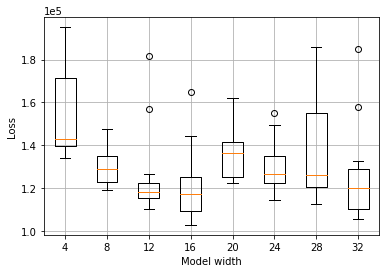

In [8]:
# Plotting results for different numbers of filters
# plot validation loss
plt.boxplot(val_loss_hist[:,30:].transpose(),labels=model_width)
plt.grid(True)
plt.xlabel('Model width')
plt.ylabel('Loss')
plt.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

plt.savefig('train_val_loss_history.png', bbox_inches='tight')
plt.show()

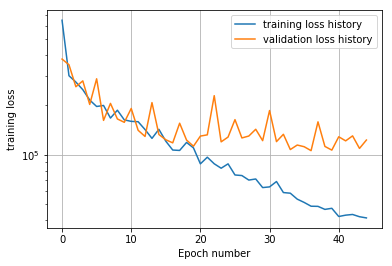

In [7]:
# Plotting final results
# plot training loss history
plt.plot(train_loss_hist[7,:],label= 'training loss history')
plt.plot(val_loss_hist[7,:],label= 'validation loss history')
plt.yscale('log')
plt.grid(True)
plt.xlabel('Epoch number')
plt.ylabel('training loss')
plt.legend()
plt.savefig('train_val_loss_history.png', bbox_inches='tight')
plt.show()

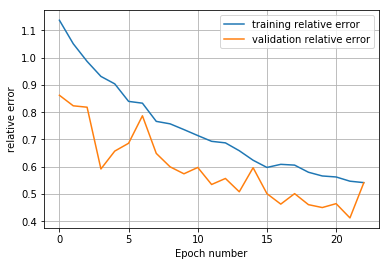

In [9]:
# plot relative error history
plt.plot(train_error_hist[7:], label='training relative error')
plt.plot(val_error_hist[7:], label='validation relative error')
plt.grid(True)
plt.xlabel('Epoch number')
plt.ylabel('relative error')
plt.legend()
plt.savefig('relative_error.png', bbox_inches='tight')
plt.show()

In [21]:
idx1 = np.arange(0,491) # a sunny day at 12-20-16
idx2 = np.arange(2730,3145) # a cloudy day at 1-1-17
idx3 = np.arange(5420,5843) # a rainy  day at 1-8-17

idx = np.concatenate((idx1,idx2,idx3))

print(idx.shape)

(1329,)


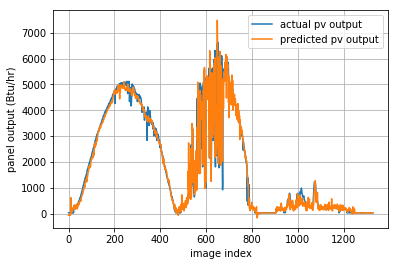

RMSE:  343.589


In [22]:
idx= idx
feed_dict = {x_var: images[idx],y_var: pv_out[idx],is_training: False}

mse,pred_y_value = sess.run([mean_loss,pred_y_var], feed_dict=feed_dict)

plt.plot(pv_out[idx], label='actual pv output')
plt.plot(pred_y_value, label='predicted pv output')
plt.grid(True)
plt.xlabel('image index')
plt.ylabel('panel output (Btu/hr)')
plt.legend()
plt.savefig('predicted_and_actual_output.png', bbox_inches='tight')
plt.show()

print('RMSE: ', np.sqrt(mse))